In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import feather
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
IMG_SOURCE_PATH = "H:/Project Data/manifest-1600709154662/data/nodules2D/"
IMG_DEST_PATH = "H:/Project Data/manifest-1600709154662/data"

DF_PATH = os.path.join("resources","annotation_df.feather")
FILE_EXT = ".png"

In [3]:
df_ann = feather.read_dataframe(DF_PATH)

In [4]:
print(df_ann.shape)
print(df_ann.head())

(6859, 16)
       patient_id nodule_id annotation_id scan_id  sublety  internalstructure  \
0  LIDC-IDRI-0078         4             2       1        4                  1   
1  LIDC-IDRI-0078     12329             6       1        4                  1   
2  LIDC-IDRI-0078     16317            10       1        5                  1   
3  LIDC-IDRI-0078      2054            13       1        5                  1   
4  LIDC-IDRI-0078         3             1       1        5                  1   

   calcification  sphericity  margin  lobulation  spiculation  texture  \
0              6           4       4           1            2        5   
1              6           4       2           2            1        5   
2              6           4       4           4            4        5   
3              6           4       3           2            2        4   
4              6           3       4           1            1        5   

   malignancy  nodule_number patient_number nodule_idx  


In [5]:
source_img_fnames = os.listdir(IMG_SOURCE_PATH)
source_img_idx = [x[:-(len(FILE_EXT))]for x in source_img_fnames]
df_ann = df_ann[df_ann.nodule_idx.isin(source_img_idx)]
print(df_ann.shape)

(6856, 16)


In [6]:
group_vars = ["nodule_idx","nodule_number","patient_id","scan_id","patient_number"]
df = df_ann.groupby(group_vars,as_index=False).agg({'spiculation':['median','mean','min','max','var'],"annotation_id":'count'}).rename(columns={'annotation_id':'n_annotations'})
new_colnames = ["_".join(x).strip() for x in df.columns.values]
new_colnames = [x.rstrip("_") for x in new_colnames]
df.columns = new_colnames

print(df.head())
print(df.shape)

  nodule_idx  nodule_number      patient_id scan_id patient_number  \
0     000101            1.0  LIDC-IDRI-0001      12           0001   
1     000201            1.0  LIDC-IDRI-0002      13           0002   
2     000301            1.0  LIDC-IDRI-0003      14           0003   
3     000302            2.0  LIDC-IDRI-0003      14           0003   
4     000303            3.0  LIDC-IDRI-0003      14           0003   

   spiculation_median  spiculation_mean  spiculation_min  spiculation_max  \
0                 4.5              4.25                3                5   
1                 1.0              1.00                1                1   
2                 1.0              1.00                1                1   
3                 2.5              3.00                2                5   
4                 1.5              1.50                1                2   

   spiculation_var  n_annotations_count  
0         0.916667                    4  
1         0.000000              

(array([1660.,  378.,  211.,  115.,   31.,  109.,   42.,   47.,   24.,
          31.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

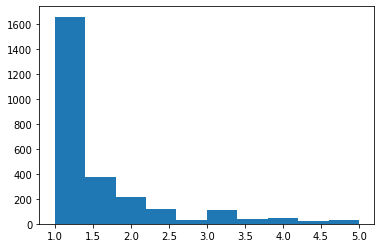

In [7]:
plt.hist(df.spiculation_mean)

In [8]:
df["label"] = (df.spiculation_mean >= 2).astype(int)
df["id"] = df.nodule_idx
ids = df.id

In [9]:
np.random.seed(12345)
valid_prop = .0
test_prop  = .2
valid_size = int(len(ids) * valid_prop)
test_size = int(len(ids) * test_prop)

valid_ids = list(np.random.choice(ids, replace = False, size = valid_size))
test_ids  = list(np.random.choice(list(set(ids) - set(valid_ids)), size = test_size))
train_ids = list(set(ids) - (set(valid_ids +  test_ids)))
split_dict = dict(zip(train_ids + valid_ids + test_ids,
                     ["train"] *len(train_ids) + ["valid"]*len(valid_ids) + ["test"] * len(test_ids)))

df["split"] = df.id.map(split_dict)
# print(df.split.value_counts())
df["out_name"] = df.id.apply(lambda x: x + FILE_EXT)
# df["out_name"] = df.apply(lambda x: x["pid"] + "_" + x["voi_name"] + FILE_EXT, axis = 1)
df["out_dir"] = df.apply(lambda x: os.path.join(x["split"], x["out_name"]), axis = 1)
df["orig_path"] = df.out_name.apply(lambda x: os.path.join(IMG_SOURCE_PATH, x))
# df["label"] = df.voi_name.apply(lambda x: int(bool(body_regex.match(x))))
df.head()

,nodule_idx,nodule_number,patient_id,scan_id,patient_number,spiculation_median,spiculation_mean,spiculation_min,spiculation_max,spiculation_var,n_annotations_count,label,id,split,out_name,out_dir,orig_path
0,000101,1.0,LIDC-IDRI-0001,12,0001,4.5,4.25,3,5,0.916667,4,1,000101,train,000101.png,train\000101.png,H:/Project Data/manifest-1600709154662/data/no...
1,000201,1.0,LIDC-IDRI-0002,13,0002,1.0,1.00,1,1,0.000000,2,0,000201,train,000201.png,train\000201.png,H:/Project Data/manifest-1600709154662/data/no...
2,000301,1.0,LIDC-IDRI-0003,14,0003,1.0,1.00,1,1,NaN,1,0,000301,train,000301.png,train\000301.png,H:/Project Data/manifest-1600709154662/data/no...
3,000302,2.0,LIDC-IDRI-0003,14,0003,2.5,3.00,2,5,2.000000,4,1,000302,train,000302.png,train\000302.png,H:/Project Data/manifest-1600709154662/data/no...
4,000303,3.0,LIDC-IDRI-0003,14,0003,1.5,1.50,1,2,0.333333,4,0,000303,train,000303.png,train\000303.png,H:/Project Data/manifest-1600709154662/data/no...


In [12]:

if not os.path.isdir(os.path.join(IMG_DEST_PATH,"train")):
    #os.makedirs(IMG_DEST_PATH)
    os.makedirs(os.path.join(IMG_DEST_PATH, "train"))
    os.makedirs(os.path.join(IMG_DEST_PATH, "valid"))
    os.makedirs(os.path.join(IMG_DEST_PATH, "test"))

    
for i, row in tqdm(df.iterrows()):
    in_path = row["orig_path"]
    out_path = os.path.join(IMG_DEST_PATH, row["split"], row["out_name"])
    shutil.copy(in_path, out_path)

2648it [00:26, 100.14it/s]


In [16]:
df.to_csv(os.path.join(IMG_DEST_PATH,"labels.csv"),index = False)